# **Boosting**

Same as bagging, boosting is also one of ensemble learning method. But differnt from bagging that building model parallelly, boosting sequentially builds the model and next model will more emphasize on the data wrong classified or with higher error.

<img src="img/boosting.png" width="600">  

### **Adaptive Boosting (AdaBoost)**

Adaptive Boosting is a refind boosting, the way to update the wieghtage is to let the model's error rate to be $0.5$.

For example, here are 5 data trained by a classifier and 1 data is wrong, so the error rate is $0.2$, if we would like to let the error rate to be $0.5$, then need to change to weightage of the data wrong classified as $0.5$, and other as $0.125$, so that the error rate will be $0.5$.

<img src="img/adaboost_weightage.png" width="600">  

#### **How to update the weightage?**

Assumed that the original weightage of each data point is equal and defined as $w_1$, $f_1$ is first classfier.
$$\delta(f_1(x_i)\ne y_i) = \begin{cases} 1, \quad f_1(x_i) \ne y_i \\ 0, \quad f_1(x_i) = y_i \end{cases} $$

then the error rate of $f_n$ can be expressed as,

$$\frac{\Sigma_i w_1^i\delta(f_1(x_i)\ne y_i)}{\Sigma_i w_1^i}$$

when data wrong classified $\delta(f_n(x_i)\ne y_i), w_2^i\leftarrow w_1^i \times d_1 $  
when data correctly classified $\delta(f_n(x_i)= y_i), w_2^i\leftarrow \frac{w_1^i}{d_1} $

so the next quesion is, how we get $d_i$?  
By resolving the following equation

$$\frac{\Sigma_i w_2^i\delta(f_1(x_i)\ne y_i)}{\Sigma_i w_2^i} = 0.5$$
$$\frac{\Sigma_{f_1(x_i)\ne y_i} w_1^i\times d_1}{\Sigma_{f_1(x_i)\ne y_i} w_1^i\times d_1+\Sigma_{f_1(x_i)=y_i} \frac{w_1^i}{d_1}} = 0.5$$


the final result is $d_1 = \sqrt{\frac{1-\epsilon}{\epsilon}}$, where $\epsilon=\frac{\Sigma_i w_1^i\delta(f_1(x_i)\ne y_i)}{\Sigma_i w_1^i}$,which is the error rate of the first classfier.


#### **How to agrregate the prediction of all weak models?**

Here we use *SAMME* (Stagewise Additive Modeling using a Multi-class Exponential loss) to give weighatge to the prediction of each weak model,

$$SAMME=\text{log}(\frac{1-error}{error})+\text{log}(n-1)$$

where $n$ is label count.

In [ ]:
# Load libraries
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import math

from scripts.models import DecisionTreeClassifier


class AdaBoostClassifier:
    def __init__(self, n_learners: int = 8, sample_percentage: float = 0.8):
        """
        Args:
            n_learners (int): number of decision trees
            sample_percentage (float): percentage of data to be used to train each tree
        """
        self.n_learners = n_learners
        self.sample_percentage = sample_percentage

    def update_weightage(self):
        """Update the weightage of the samples according to the error rate of the learner"""
        y_pred = self.learner.predict(self.X)
        error = np.sum(self.weights * (y_pred != self.y))
        self.amount_of_say.append(math.log((1 - error) / error)+math.log(self.label_count-1))
        d = math.sqrt((1 - error) / error)
        self.weights[y_pred != self.y] *= d
        self.weights[y_pred == self.y] /= d
        self.weights /= np.sum(self.weights)

    def update_train_data(self):
        """Update the training data according to the wieghtage and sample percentage"""
        n_samples = self.X.shape[0]
        sample_size = int(n_samples * self.sample_percentage)
        idx = np.random.choice(n_samples, size=sample_size, replace=True, p=self.weights)
        return self.X[idx], self.y[idx]
        
    def fit(self, X: np.array, y: np.array):
        """Build the AdaBoost model
        Args:
            X: np.array: feature matrix
            y: np.array: target vector
        """
        self.X = X
        self.y = y
        X_sampled = X
        y_sampled = y
        self.n_samples = len(y)
        self.label_count = len(np.unique(y))
        self.weights = np.ones(self.n_samples) / self.n_samples
        self.learners = []
        self.amount_of_say = []

        for i in range(self.n_learners):
            self.learner = DecisionTreeClassifier(max_depth=1)
            self.learner.fit(X_sampled, y_sampled)
            self.update_weightage()
            X_sampled, y_sampled = self.update_train_data()
            self.learners.append(self.learner)

    def predict(self, X: np.array) -> np.array:
        """Predict the target vector
        Args:
            X: np.array: feature matrix
        Returns:
            np.array: predicted target vector
        """
        pred_scores = np.zeros(shape=(self.n_learners, X.shape[0], self.label_count))
        for idx, learner in enumerate(self.learners):
            pred_prob = learner.get_pred_prob(X)
            pred_scores[idx] = np.array(pred_prob)*self.amount_of_say[idx]
        avg_pred_scores = np.mean(pred_scores, axis=0)
        return np.argmax(avg_pred_scores, axis=1)
    

Accuracy: 93 %


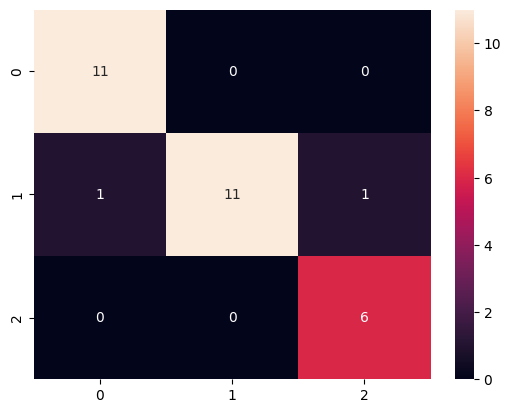

In [2]:
# load iris dataset
iris = datasets.load_iris()
X=np.array(iris.data)
y = np.array(iris.target)

# Split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Build up the decision tree classifier
abc = AdaBoostClassifier()
abc.fit(X_train, y_train)

# Predict on testing data
y_pred = abc.predict(X_test)


cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, annot_kws={"size": 10})


acc = np.sum(y_test==y_pred)/len(y_pred)
print("Accuracy: {} %".format(round(acc*100),2))

### Gradient Boost

Gredient boosting is ideated from gradient descent. Gradient descent update the parameters with the hint of devirate values, and grdient boosting is to predict on gradient and continually update $y$ value by predicted gradient.

$$Gradient_i = y_i - y_i^{pred}$$

In [ ]:
import pandas as pd
import seaborn as sns
from scripts.models import DecisionTreeRegressor

class GradientBoostingRegressor:
    def __init__(self, epochs: int=100, learning_rate: float=0.1):
        """
        Args:
            epochs (int): number of epochs
            learning_rate (float): learning rate
        """
        self.epochs = epochs
        self.learning_rate = learning_rate

    def calculate_grdient(self, y: np.array, y_pred: np.array) -> np.array:
        """Calculate the gradient of the loss function
        Args:
            y: np.array: target vector
            y_pred: np.array: predicted target vector
        Returns:
            np.array: gradient of the loss function
        """
        return -(y - y_pred)
    
    def calculate_loss(self, y: np.array, y_pred: np.array) -> float:
        """Calculate the loss function
        Args:
            y: np.array: target vector
            y_pred: np.array: predicted target vector
        Returns:
            float: loss value
        """
        return np.sqrt(np.mean((y - y_pred)**2))

    def fit(self, X: np.array, y: np.array):
        self.X = X
        self.y = y
        self.models = []
        self.losses = []
        y_pred = np.zeros(len(y)).reshape(-1, 1)*np.mean(y)
        for _ in range(self.epochs):
            if _ + 1 % 10 == 0:
                print("Epoch: ", _, "Loss: ", self.calculate_loss(y, y_pred))
            residual = self.calculate_grdient(y, y_pred)
            model = DecisionTreeRegressor(max_depth=1)
            model.fit(X, residual)
            m_pred = model.predict(X).reshape(-1,1)
            y_pred -= self.learning_rate*m_pred
            self.models.append(model)
            self.losses.append(self.calculate_loss(y, y_pred))
            if _ > 10:
                if (self.losses[-2] - self.losses[-1]) < 0.001:
                    print("Epoch: ", _, "Loss: ", self.calculate_loss(y, y_pred))
                    break

    def predict(self, X: np.array) -> np.array:
        """Predict the target vector
        Args:
            X: np.array: feature matrix
        Returns:
            np.array: predicted target vector
        """
        y_pred = np.zeros(len(X)).reshape(-1, 1)*np.mean(self.y)
        for model in self.models:
            y_pred -= self.learning_rate*model.predict(X).reshape(-1, 1)
        return y_pred

    def plot_loss(self):
        """Plot the loss function"""
        df = pd.DataFrame({'epochs': range(1, len(self.losses)+1), 'losses': self.losses})
        sns.set_theme()
        sns.lineplot(x='epochs', y='losses', data=df)

Epoch:  49 Loss:  77.93804212263113
RMSE:  73.1980762654574


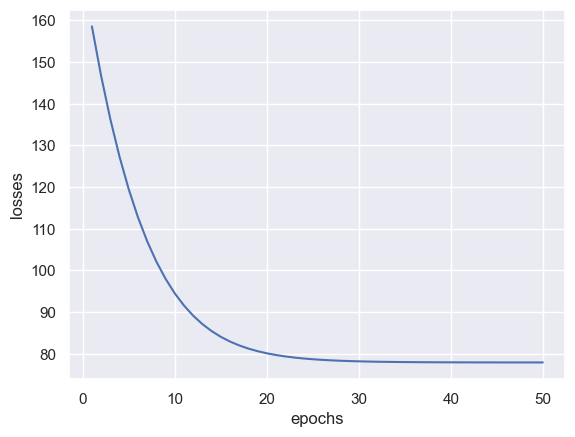

In [4]:
from sklearn.datasets import load_diabetes

diabate = load_diabetes()
X = diabate.data
y = diabate.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

gb = GradientBoostingRegressor()

gb.fit(X_train, y_train)

gb.plot_loss()

y_pred = gb.predict(X_test)

print('RMSE: ', np.sqrt(np.mean((y_test - y_pred) ** 2 )))

#### Reference
https://chih-sheng-huang821.medium.com/機器學習-ensemble-learning之bagging-boosting和adaboost-af031229ebc3
https://github.com/enesozeren/machine_learning_from_scratch/blob/main/decision_trees/adaboost.py
https://github.com/srikhetramohanty/Data-Science-Portfolio/blob/main/ML%20From%20Scratch/Supervised%20ML%20From%20Scratch/Tree%20Family/gradient-boosting-from-scratch-regression.ipynb